In [39]:
import os
from tqdm import tqdm
import spatialdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ad
import squidpy as sq
import networkx as nx
import spatialdata

from shapely.ops import unary_union

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer

from utils.utils_colors import cn_color_palette, cell_color_dict
from utils.utils_geom import align_sample_polygons

In [40]:
cfg = STConfig()
adata = ad.read_h5ad(cfg.pth_consol_adata)
adata

AnnData object with n_obs × n_vars = 5843348 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch'
    obsm: 'spatial'

### Visualizing Different Ways to Contruct Graph for Cell Charter

Below we illustrate different approaches which could be used for constructing graphs to be used as input to cell charter

#### Delaunay Triangulation without distance threshold

In [4]:
def visualize_graph(adata):
    G = nx.Graph()
    G = nx.from_scipy_sparse_array(adata.obsp["spatial_connectivities"]) 

    coords = adata.obsm["spatial"]
    pos_dict = {i: tuple(coords[i]) for i in range(coords.shape[0])}
    nx.set_node_attributes(G, pos_dict, name="pos")

    pos=nx.get_node_attributes(G,'pos')
    fig, ax = plt.subplots(1, 1, figsize=(7, 21))
    ax.set_aspect('equal', 'box')
    nx.draw(G, pos, node_size=0.1, ax=ax)

In [5]:
sample_id = '10693_R1'
adata_sub = adata[adata.obs['cell_id'].str.contains(sample_id)].copy()

In [6]:
adata_sub_itr = adata_sub[adata_sub.obs['it_regions'] != "non_intertrabecular"]
mask = ~np.isnan(adata_sub_itr.obsm["spatial"]).any(axis=1)
adata_sub_itr = adata_sub_itr[mask].copy()
adata_sub_itr

AnnData object with n_obs × n_vars = 437214 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch'
    obsm: 'spatial'

#### Delaunay Triangulation with distance threshold without distance threshold

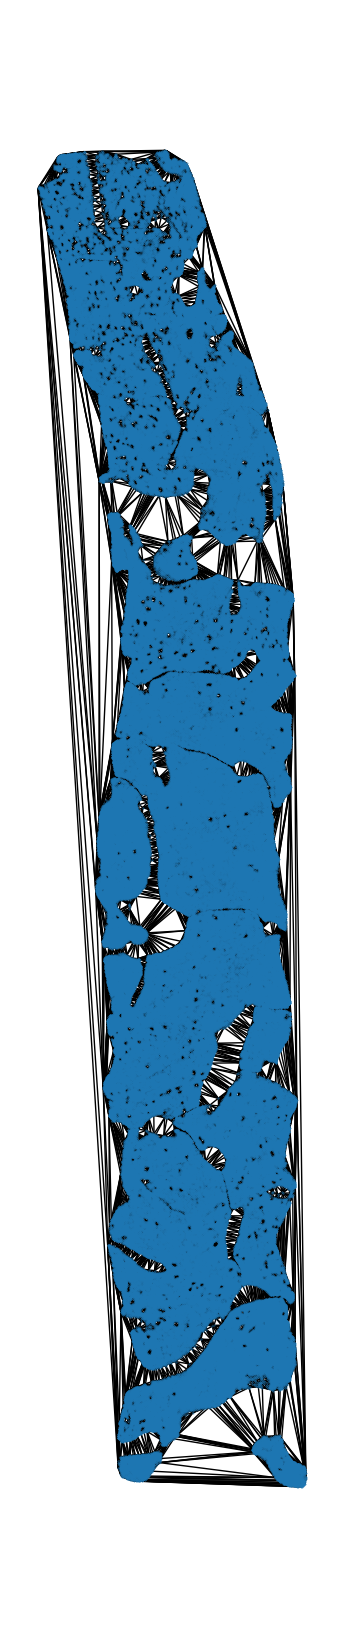

In [7]:
sq.gr.spatial_neighbors(adata_sub_itr, coord_type="generic", delaunay=True)
visualize_graph(adata_sub_itr)

#### Delaunay Triangulation with distance threshold (0, 100)

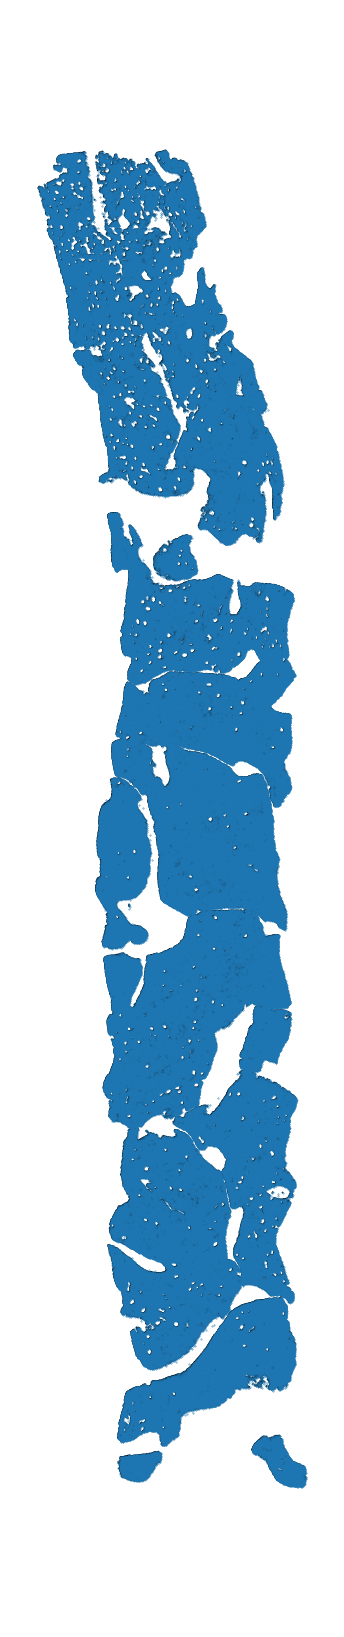

In [8]:
sq.gr.spatial_neighbors(adata_sub_itr, coord_type="generic", delaunay=True, radius=(0, 100))
visualize_graph(adata_sub_itr)

#### Graph Used in the paper touching polygon

In [9]:
customizer = SDataCustomizer(cfg, sample_key=sample_id)
sdata_file_path = f'{cfg.pth_sdata}/{sample_id}_no_he.zarr'
sdata_obj = spatialdata.read_zarr(sdata_file_path)

In [10]:
cell_status_df = adata_sub_itr.obs[['extra_new_cell_status', 'meg_phenotype']]
cell_status_df.head(2)

,extra_new_cell_status,meg_phenotype
aaaaoblp-1_10693_R1,original,non_meg
aaabbnpb-1_10693_R1,original,non_meg


In [11]:
gdf_cells = sdata_obj["new_cell_boundaries"].copy()
merged_gdf = gdf_cells.merge(cell_status_df, left_index=True, right_index=True)
merged_gdf.head(2)

,geometry,extra_new_cell_status,meg_phenotype
aaaaoblp-1_10693_R1,"POLYGON ((3986.000 81925.000, 3983.000 81936.0...",original,non_meg
aaabbnpb-1_10693_R1,"POLYGON ((3963.000 81953.998, 3957.000 81955.0...",original,non_meg


In [12]:
gdf_art = merged_gdf.loc[merged_gdf['extra_new_cell_status'] == 'artefact', ['meg_phenotype', 'geometry']].copy()
gdf_meg = merged_gdf.loc[merged_gdf['meg_phenotype'] != "non_meg", ['meg_phenotype', 'geometry']].copy()

# getting touching polygon artefact and non-megs to merge it for better graph
gdf_art["geometry"] = gdf_art.buffer(10)
gdf_meg["geometry"] = gdf_meg.buffer(10)
sjoined = gdf_meg.sjoin(gdf_art, how="inner", predicate="intersects")
sjoined.head(3)

,meg_phenotype_left,geometry,index_right,meg_phenotype_right
0_10693_R1,7.0,"POLYGON ((11531.700 27272.447, 11531.753 27273...",abdckhdf-1_10693_R1,non_meg
0_10693_R1,7.0,"POLYGON ((11531.700 27272.447, 11531.753 27273...",abdcjnlf-1_3_10693_R1,non_meg
1_10693_R1,6.0,"POLYGON ((15026.256 77155.685, 15026.308 77156...",faggcamg-1_10693_R1,non_meg


In [13]:
meg_idices = sjoined.index.tolist()
arf_idices = sjoined.index_right.tolist()

# merge the touching artefact boundary to each meg
for idx, meg_idx in enumerate(meg_idices):
    gdf_meg.loc[meg_idx, "geometry"] = gdf_meg.loc[meg_idx, "geometry"].union(gdf_art.loc[arf_idices[idx], "geometry"])

gdf_meg["geometry"] = gdf_meg.buffer(-10)

In [14]:
# Getting a copy of cell geometry from sdata object 
gdf_cells_new = sdata_obj["new_cell_boundaries"].copy()
new_gdf = gdf_cells_new.drop(gdf_art.index)

new_gdf.loc[gdf_meg.index, "geometry"] = gdf_meg["geometry"]

# Selecting common index we are using for graph construction
final_indexes = new_gdf.index.intersection(adata_sub_itr.obs.index.tolist())
print(f"Total Cell Selected {len(final_indexes)}")
new_gdf = new_gdf.loc[final_indexes]

Total Cell Selected 434645


In [15]:
from geopandas import GeoDataFrame
# Defining graph connectivity
new_gdf = new_gdf.buffer(2)
gdf = GeoDataFrame(new_gdf, columns=["geometry"], index=new_gdf.index)
# self joint to identify touching polygon
sjoined = gdf.sjoin(gdf, how="left", predicate="intersects")
print(f"# of cell id {len(final_indexes)}, merged df shape {sjoined.shape}")

# of cell id 434645, merged df shape (3103337, 2)


In [16]:
index_map = {key: idx for idx, key in enumerate(final_indexes)}
edges = {
    (ix, iy) if ix < iy else (iy, ix)
    for x, y in zip(sjoined.index, sjoined.index_right)
    if x != y
    for ix, iy in [(index_map.get(x, -1), index_map.get(y, -1))]
}
centroids = gdf.geometry.centroid
coords = np.column_stack((centroids.x.values, centroids.y.values))

#### Visualizing the Graph Constructed using touching polygon

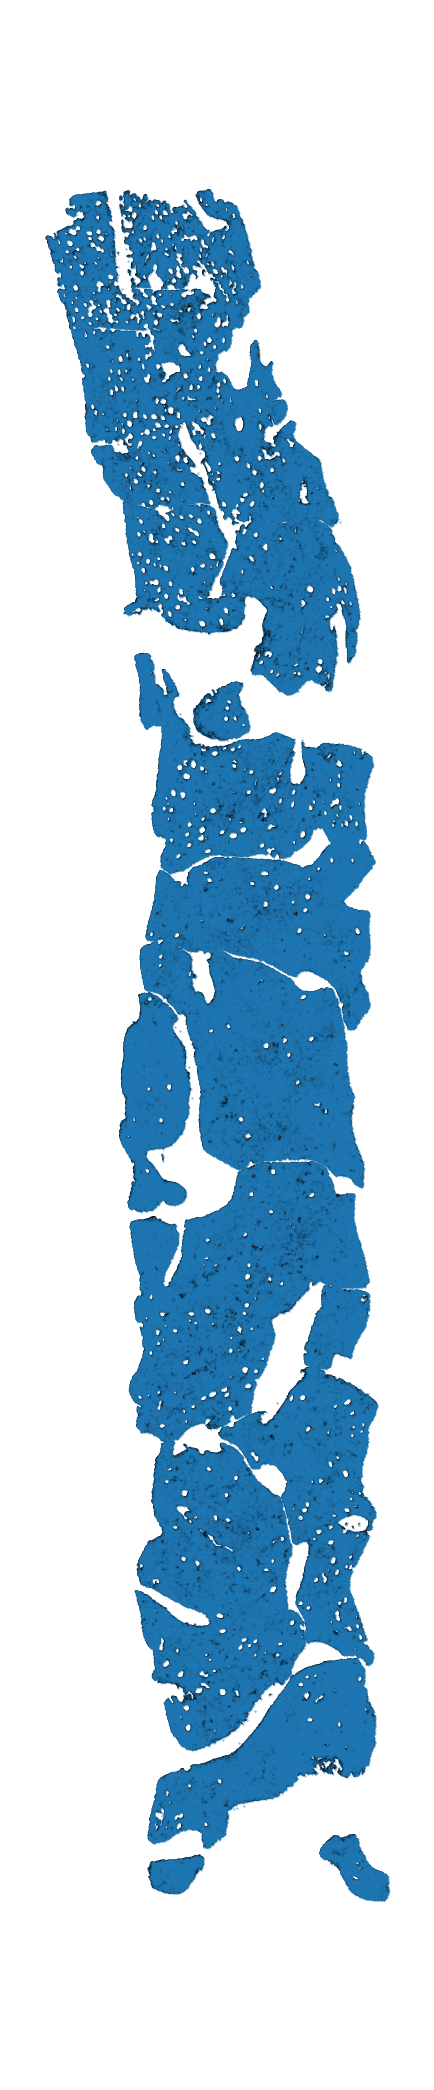

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
pos_dict = {i: tuple(coords[i]) for i in range(coords.shape[0])}
G.add_edges_from(edges)
G.add_nodes_from(pos_dict)
fig, ax = plt.subplots(1, 1, figsize=(7, 21))
ax.set_aspect('equal', 'box')
nx.draw(G, pos_dict, node_size=0.1, ax=ax)
plt.tight_layout()
plt.show()

#### Reading Cell annotation to color polygon by cell type

In [46]:
# reading cell annotation 
skey = 'sample_id'
cell_type_col = 'obj.anno_3_w_megs_w_stromal'
annot_df = pd.read_csv(cfg.pth_cell_annotations_final)
annot_df[skey] = annot_df['cell_id'].str[-8:]
annot_df = annot_df.loc[:, [skey,'cell_id' ,cell_type_col]]
annot_df.index = annot_df['cell_id'].tolist()
annot_df.head(2)

/tmp/slurm-2073957/ipykernel_2775889/3241745481.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv(cfg.pth_cell_annotations_final)


,sample_id,cell_id,obj.anno_3_w_megs_w_stromal
aaabbbkl-1_10693_R2,10693_R2,aaabbbkl-1_10693_R2,DC
aaabpmkp-1_10693_R2,10693_R2,aaabpmkp-1_10693_R2,Erythroid


In [50]:
# dropping cell with no avilable cell type info or cells that are CD69
annot_df = annot_df.dropna(subset=cell_type_col)
annot_df[~annot_df[cell_type_col].isin(['CD69'])]

# taking innter join of cell_gdf and cell anotation dataframe
cells_gdf = gdf.merge(annot_df, left_index=True, right_index=True)
cells_gdf.head(2)

,geometry,sample_id,cell_id,obj.anno_3_w_megs_w_stromal
aaaaoblp-1_10693_R1,"POLYGON ((3986.000 81923.000, 3985.800 81923.0...",10693_R1,aaaaoblp-1_10693_R1,SMC
aaabbnpb-1_10693_R1,"POLYGON ((3963.000 81951.998, 3962.835 81952.0...",10693_R1,aaabbnpb-1_10693_R1,Plasma_cell


In [51]:
# getting max and min bounds covered by geometry
minx, miny, maxx, maxy = cells_gdf.geometry.total_bounds
print(minx, miny, maxx, maxy)

1469.0008147234787 11165.000229779413 18375.999061879946 95071.9984514104


In [52]:
cells_gdf["cell_color"] = cells_gdf[cell_type_col].map(cell_color_dict)
cells_gdf.head(2)

,geometry,sample_id,cell_id,obj.anno_3_w_megs_w_stromal,cell_color
aaaaoblp-1_10693_R1,"POLYGON ((3986.000 81923.000, 3985.800 81923.0...",10693_R1,aaaaoblp-1_10693_R1,SMC,#CD5C5C
aaabbnpb-1_10693_R1,"POLYGON ((3963.000 81951.998, 3962.835 81952.0...",10693_R1,aaabbnpb-1_10693_R1,Plasma_cell,#7edc89


(24100.0, 24500.0)

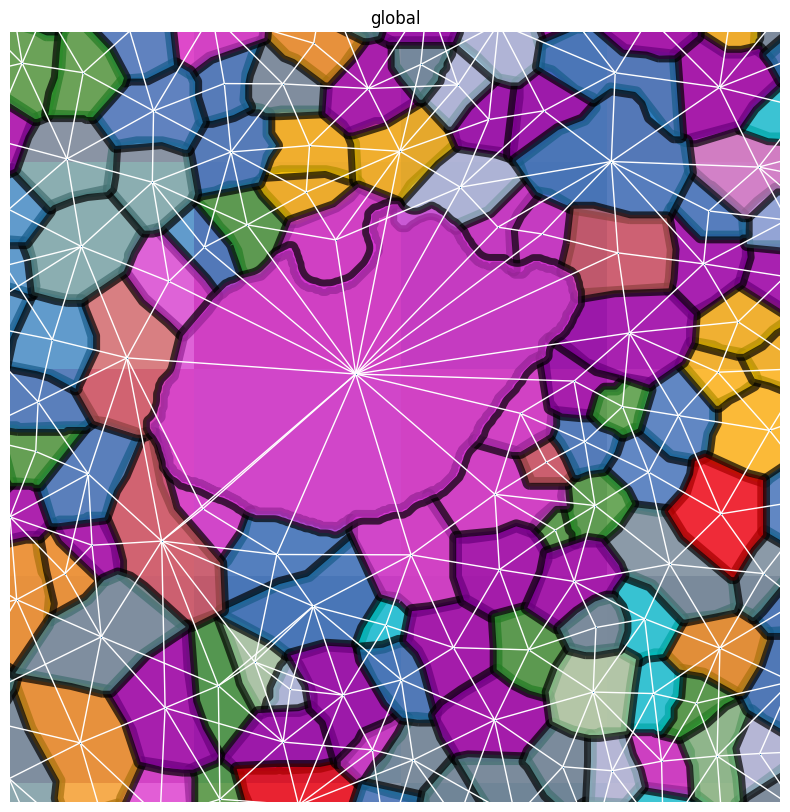

In [55]:
import spatialdata_plot
f, ax = plt.subplots(1, 1, figsize=(10, 10))

cells_gdf.plot(ax=ax, color=cells_gdf["cell_color"], edgecolor='black', linewidth=5, alpha=0.7)
sdata_obj.pl.render_images("07_24_55").pl.show("global", ax=ax)
# plotting graph from previous step for illustration purpose
nx.draw(G, pos_dict, node_size=0.1, ax=ax, edge_color='white', linewidths=0.5)
ax.set_xlim(9000, 9400)
ax.set_ylim(24100, 24500)